<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigure1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
from IPython.display import Image
import warnings
from scipy.stats import ttest_rel
from statsmodels.stats.power import TTestPower

warnings.filterwarnings("ignore")

In [ ]:
# @title Figure 1A
Image(url='https://github.com/yiruchen4/Chen2025/blob/main/Images/Figure%201A.png?raw=true', width=600)

In [ ]:
# @title Figure 1B
Image(url='https://github.com/yiruchen4/Chen2025/blob/main/Images/Figure%201B.png?raw=true', width=600)

In [ ]:
# @title Figure 1C
Image(url='https://github.com/yiruchen4/Chen2025/blob/main/Images/Figure%201C.png?raw=true', width=600)

In [ ]:
# @title Figure 1D
Image(url='https://github.com/yiruchen4/Chen2025/blob/main/Images/Figure%201D.png?raw=true', width=400)

Average door-opening events per day:
Empty cage period: 18.421
Social stimulus period: 48.607
Paired t-test p-value: 
0.000003


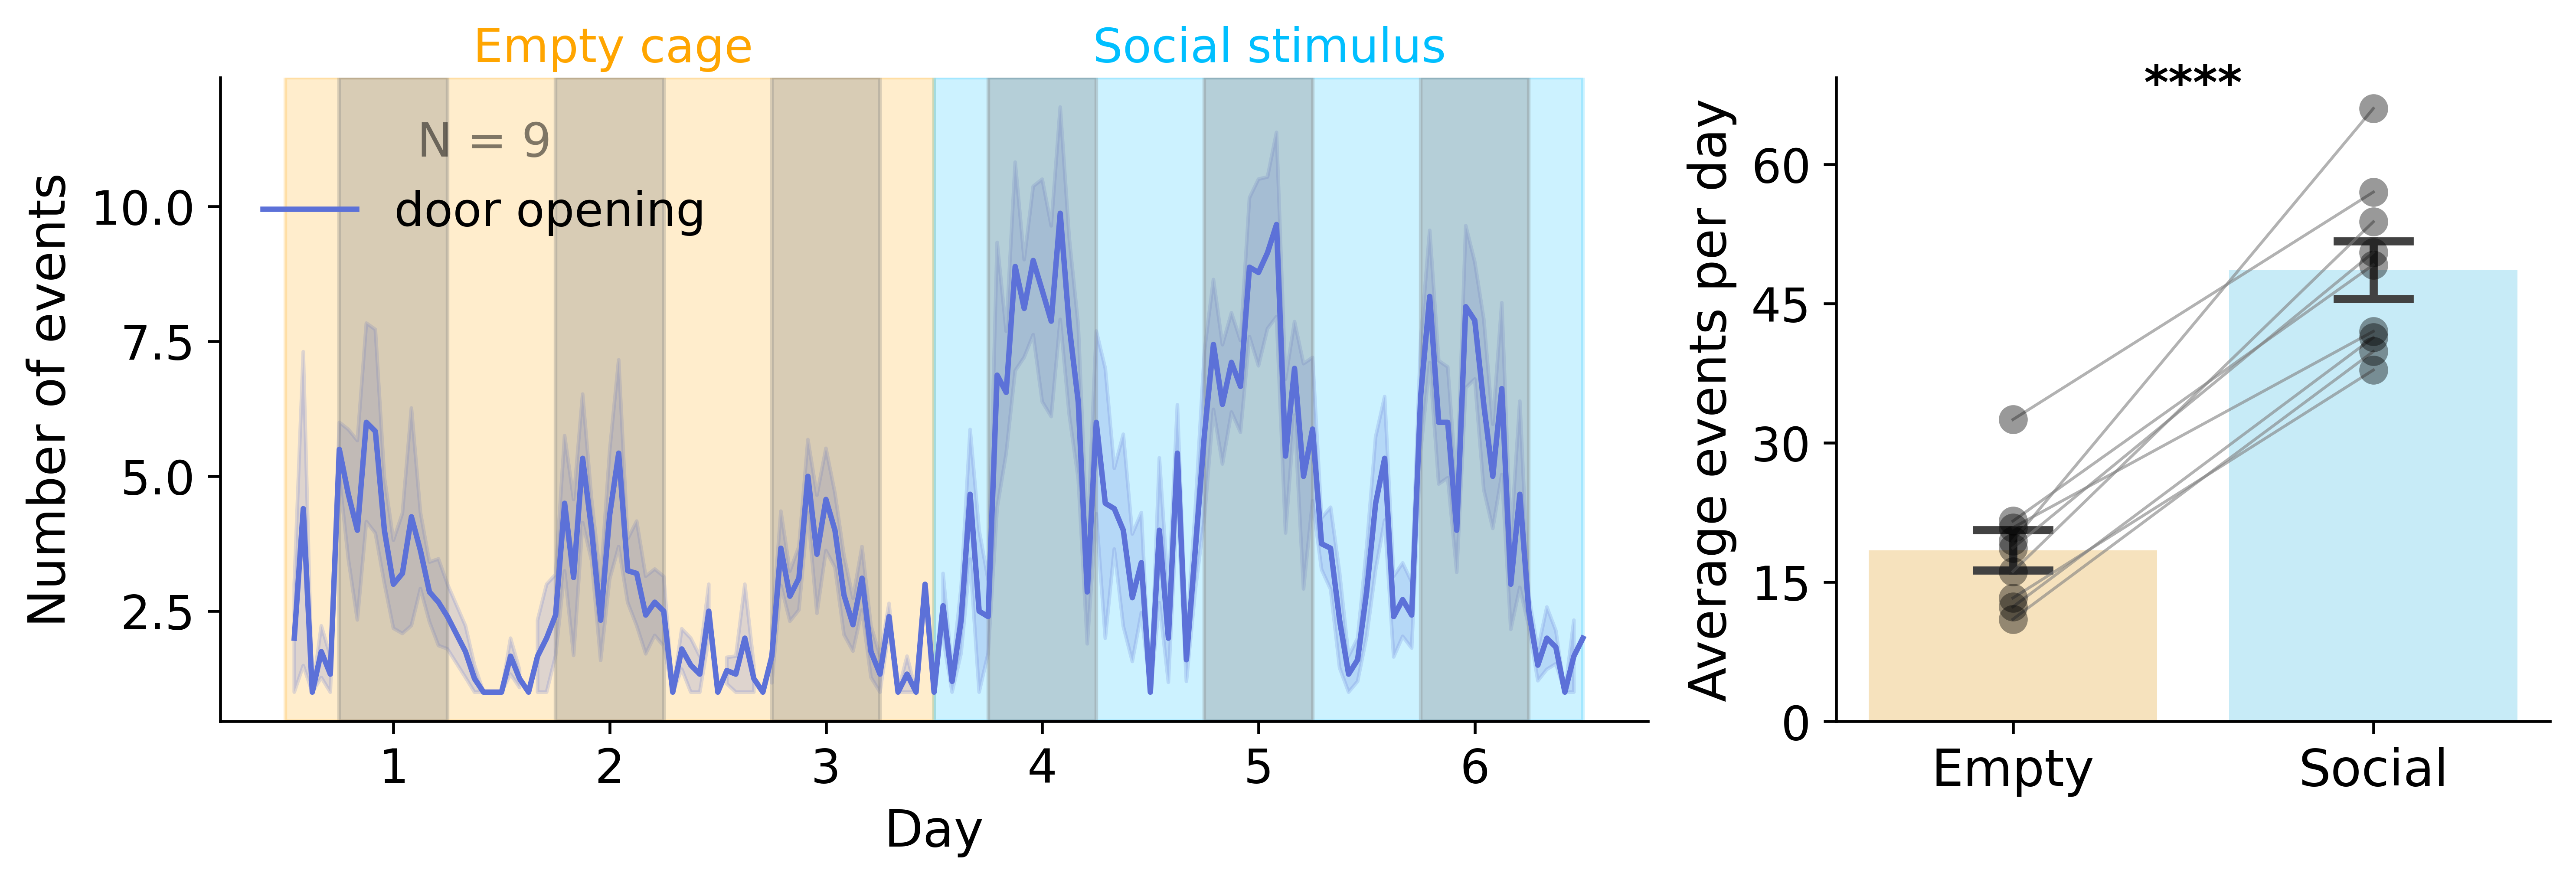

In [ ]:
# @title Figure 1E-F
# Load and preprocess data
p = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/all_DOORs_Figure1.csv")
p["datetime"] = pd.to_datetime(p["datetime"], format="mixed")
p['days'] = (p["datetime"] - pd.to_datetime("2024-10-16 12:00:00")).dt.days
p['days'] = p['days'].where(p["device_number"] < 10, (p["datetime"] - pd.to_datetime("2024-11-9 12:00:00")).dt.days)
p['hours'] = (p["datetime"] - pd.to_datetime("2024-10-16 12:00:00")).dt.total_seconds() / 3600
p['hours'] = p['hours'].where(p["device_number"] < 10, (p["datetime"] - pd.to_datetime("2024-11-9 12:00:00")).dt.total_seconds() / 3600)
p["hoursfloor"] = np.floor(p["hours"]).astype(int)
pp = p[(p["hoursfloor"] >= -72) & (p["hoursfloor"] <= 3 * 24)]

# Data for left plot (clustered door opening)
b = pp.groupby(["device_number", "hoursfloor"])["event"].count().reset_index()

# Data for right plot (paired t-test bar chart)
c = pp.groupby(["device_number", 'mode', "days", "behavior"])["event"].count().reset_index()
cc = c.groupby(['device_number', 'mode'])['event'].mean().reset_index()

before_data = np.array(cc.query('mode == "empty"')['event'])
after_data = np.array(cc.query('mode == "social"')['event'])
print("Average door-opening events per day:")
sums_combined = pd.DataFrame({'before': before_data, 'after': after_data})

# Print results
print(f"Empty cage period: {np.mean(before_data):.3f}")
print(f"Social stimulus period: {np.mean(after_data):.3f}")

# Paired t-test
t_stat, p_value = ttest_rel(before_data, after_data)
print(f'Paired t-test p-value: \n{p_value:.6f}')

# === Combined Figure ===
fig = plt.figure(figsize=(10, 3.5), dpi=600)
gs = fig.add_gridspec(1, 2, width_ratios=[3, 1.5])

# === LEFT PLOT: Clustered Door Opening ===
ax1 = fig.add_subplot(gs[0, 0])
xtick_positions = range(-60, 3 * 24 - 11, 24)
xtick_labels = [1, 2, 3, 4, 5, 6]

ax1.axvspan(-72, 0, color='orange', alpha=0.2)
ax1.axvspan(0, 3 * 24, color='deepskyblue', alpha=0.2)

sns.lineplot(data=b, x="hoursfloor", y="event", errorbar='se', color='#5C71D8', label='door opening', ax=ax1)

for start in range(-66, 3 * 24 + 1, 24):
    ax1.axvspan(start, start + 12, color="grey", alpha=0.3)

ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, fontsize=13)
ax1.tick_params(axis="y", labelsize=13)
ax1.set_xlabel("Day", fontsize=14)
ax1.set_ylabel("Number of events", fontsize=14)
ax1.yaxis.set_major_locator(MaxNLocator(5))
ax1.text(0.275, 1.025, "Empty cage", fontsize=13, color='orange', ha='center', transform=ax1.transAxes)
ax1.text(0.735, 1.025, "Social stimulus", fontsize=13, color='deepskyblue', ha='center', transform=ax1.transAxes)
legend1 = ax1.legend(title=f'N = {len(b["device_number"].unique())}', title_fontsize=13, loc="upper left", frameon=False, fontsize=13)
legend1.get_title().set_alpha(0.5)
sns.despine(ax=ax1)

# === RIGHT PLOT: Paired Bar Chart ===
ax2 = fig.add_subplot(gs[0, 1])
bar_colors = ['#FFE5B4', '#BFEFFF']
sums_melted = sums_combined.melt(var_name='Condition', value_name='Events')

sns.barplot(data=sums_melted, x='Condition', y='Events', errorbar="se", capsize=.2, palette=bar_colors, ax=ax2)
sns.stripplot(data=sums_melted, x='Condition', y='Events', color='black', jitter=False, alpha=0.4, size=8, ax=ax2)

for i in range(len(before_data)):
    ax2.plot([0, 1], [before_data[i], after_data[i]], color='gray', linestyle='-', linewidth=0.8, alpha=0.6)

ax2.set_xlabel("")
ax2.set_ylabel("Average events per day", fontsize=14)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(["Empty", "Social"], fontsize=14)
ax2.tick_params(axis="y", labelsize=13)
ax2.yaxis.set_major_locator(MaxNLocator(5))
sns.despine(ax=ax2)

def add_sig_line(ax, x1, x2, y, p_val, h=1):
    if p_val < 0.0001:
        stars = '****'
    elif p_val < 0.001:
        stars = '***'
    elif p_val < 0.01:
        stars = '**'
    elif p_val < 0.05:
        stars = '*'
    else:
        return
    ax.text((x1 + x2) / 2, y, stars, ha='center', va='bottom', fontsize=13, fontweight='bold')

# Draw significance line with stars
y_max = max(np.max(before_data), np.max(after_data))
add_sig_line(ax2, 0, 1, y_max, p_value, h=1)

plt.tight_layout()
plt.show()